# Code For Artificial Analysis Data

In [12]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt


#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
import seaborn as sns



/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/1731122314.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


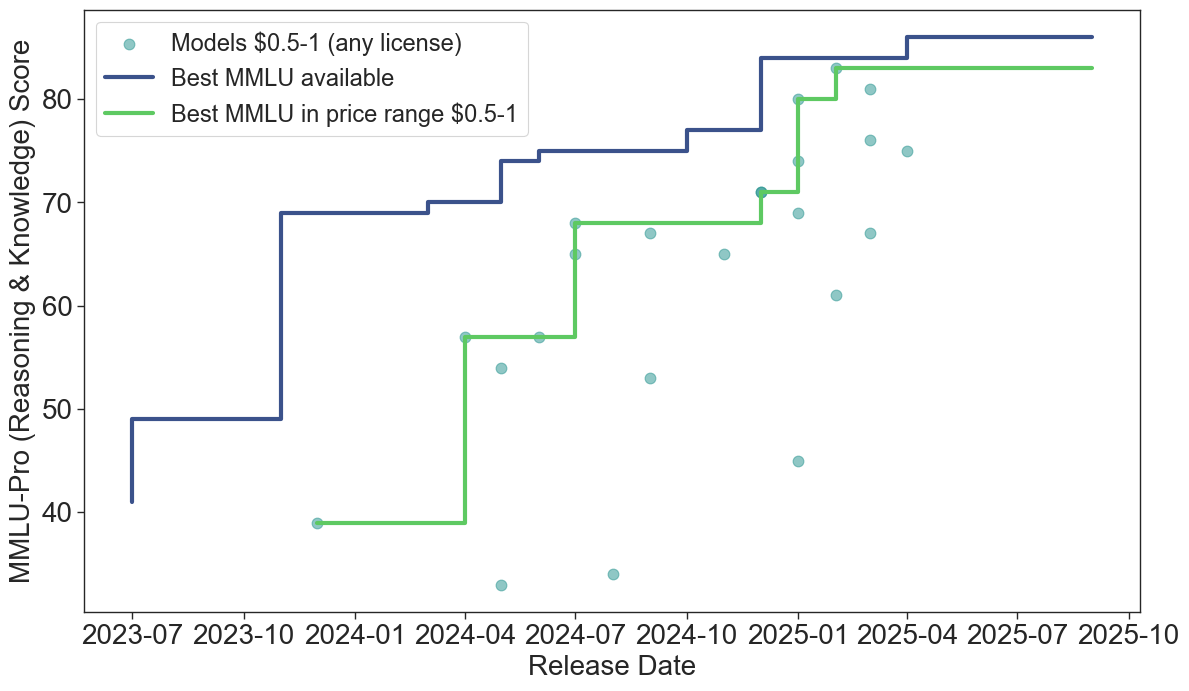

In [13]:
def compare_mmlu_to_best_over_time_any_license(lower_price, upper_price, type=None, benchmark_feature='MMLU-Pro (Reasoning & Knowledge)'):
    """
    Plots MMLU performance of models within a fixed price range (optionally filtered by license)
    vs. the best MMLU available at each release date (regardless of license).
    Also plots the best MMLU available within the specified price range.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime

    default_fontsize  = 20

    sns.set_style("ticks")
    sns.set_context("paper")
    colors = sns.color_palette("viridis", n_colors=3)

    df = pd.read_csv('datasets/art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
    # benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    # benchmark_feature = "Chatbot Arena"

    # Drop nan values
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]
    df = df[df['Output Price\nUSD/1M Tokens'].notna()]

    # Convert MMLU values to float
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)

    # Sort by release date
    df = df.sort_values('Release Date')

    # Compute best MMLU available up to each date (across all licenses)
    df['Best_MMLU_So_Far'] = df[benchmark_feature].cummax()
    best_mmlu_df = df[['Release Date', 'Best_MMLU_So_Far']].drop_duplicates(subset='Best_MMLU_So_Far')

    # Filter models in the price range (optionally by license)
    if type is not None:
        price_df = df[(df['Output Price\nUSD/1M Tokens'] >= lower_price) & 
                      (df['Output Price\nUSD/1M Tokens'] <= upper_price) &
                      (df['License'] == type)]
        label = f'Models ${lower_price}-{upper_price} ({type})'
    else:
        price_df = df[(df['Output Price\nUSD/1M Tokens'] >= lower_price) & 
                      (df['Output Price\nUSD/1M Tokens'] <= upper_price)]
        label = f'Models ${lower_price}-{upper_price} (any license)'
    
    # Compute best MMLU available up to each date within the price range
    price_df = price_df.sort_values('Release Date')
    price_df['Best_MMLU_In_Price_Range'] = price_df[benchmark_feature].cummax()
    best_price_mmlu_df = price_df[['Release Date', 'Best_MMLU_In_Price_Range']].drop_duplicates(subset='Best_MMLU_In_Price_Range')

    # Get the min and max dates from the full dataset for consistent x-axis range
    min_date = df['Release Date'].min()
    max_date = df['Release Date'].max()
    
    # Ensure the best overall MMLU plot starts from the min date and ends at the max date
    if min_date not in best_mmlu_df['Release Date'].values:
        # Add the min date with the first available best MMLU value
        first_best = best_mmlu_df.iloc[0]['Best_MMLU_So_Far']
        best_mmlu_df = pd.concat([pd.DataFrame({'Release Date': [min_date], 'Best_MMLU_So_Far': [first_best]}), 
                                 best_mmlu_df])
    
    if max_date not in best_mmlu_df['Release Date'].values:
        # Add the max date with the last available best MMLU value
        last_best = best_mmlu_df.iloc[-1]['Best_MMLU_So_Far']
        best_mmlu_df = pd.concat([best_mmlu_df, 
                                 pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_So_Far': [last_best]})])
    
    # For the best price range MMLU, start with the first actual data point
    # (don't add min_date if there's no data at that point)
    if len(best_price_mmlu_df) > 0:  # Only if we have models in the price range
        if max_date not in best_price_mmlu_df['Release Date'].values:
            # Add the max date with the last available best price range MMLU value
            last_best_price = best_price_mmlu_df.iloc[-1]['Best_MMLU_In_Price_Range']
            best_price_mmlu_df = pd.concat([best_price_mmlu_df, 
                                         pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_In_Price_Range': [last_best_price]})])
    
    # Sort the dataframes by date to ensure proper step plotting
    best_mmlu_df = best_mmlu_df.sort_values('Release Date')
    best_price_mmlu_df = best_price_mmlu_df.sort_values('Release Date')

    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(price_df['Release Date'], price_df[benchmark_feature], label=label, color=colors[1], alpha=0.5, s=60)
    plt.step(best_mmlu_df['Release Date'], best_mmlu_df['Best_MMLU_So_Far'], where='post',linewidth=3, label='Best MMLU available', color=colors[0])
    
    if len(best_price_mmlu_df) > 0:  # Only plot if we have models in the price range
        plt.step(best_price_mmlu_df['Release Date'], best_price_mmlu_df['Best_MMLU_In_Price_Range'], where='post', color=colors[2], linewidth=3, label=f'Best MMLU in price range ${lower_price}-{upper_price}')
    
    plt.xlabel('Release Date', fontsize=default_fontsize)
    plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
    plt.xticks(fontsize=default_fontsize)
    plt.yticks(fontsize=default_fontsize)
    # plt.title(f'{benchmark_feature} of models {label} vs. best available (any license)')
    plt.legend(prop={'size': 17})
    plt.tight_layout()
    plt.savefig(f'Figures/{benchmark_feature[:5]}_cost_comparison.png', dpi=300)
    plt.show()

# Example usage:

compare_mmlu_to_best_over_time_any_license(0.5, 1)  # all licenses in price range
# or, to filter price range by license:
# compare_mmlu_to_best_over_time_any_license(0.5, 1, type='Open')

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/3740374981.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


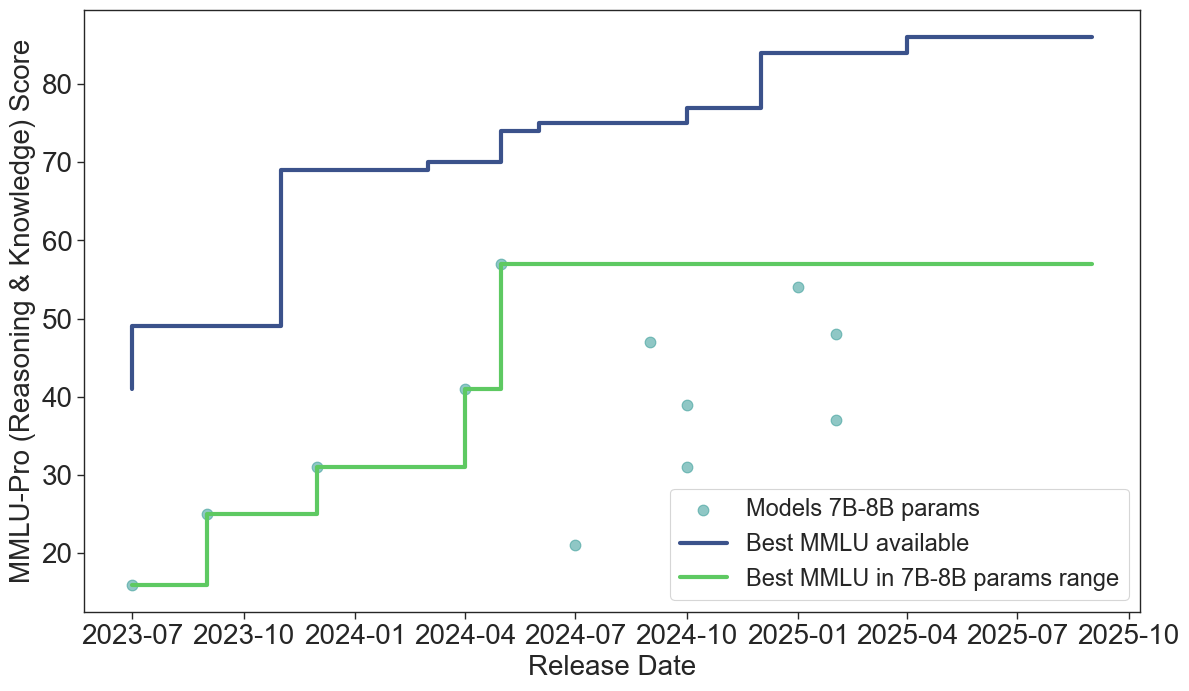

In [14]:
def compare_mmlu_to_best_over_time_by_param_count(lower_param, upper_param, benchmark_feature='MMLU-Pro (Reasoning & Knowledge)'):
    """
    Plots MMLU performance of models within a fixed parameter count range
    vs. the best MMLU available at each release date (regardless of license).
    """
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime

    sns.set_style("ticks")
    sns.set_context("paper")
    default_fontsize  = 20
    colors = sns.color_palette("viridis", n_colors=3)

    df = pd.read_csv('Datasets/art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Parameter Count'] = pd.to_numeric(df['Parameter Count'], errors='coerce')
    # benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    # benchmark_feature = "Chatbot Arena"

    # Drop nan values for required fields
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]
    
    # Create a copy of the full dataset for best overall MMLU calculation
    df_all = df.copy()

    # Convert MMLU values to float
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
        df_all[benchmark_feature] = df_all[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)
        df_all[benchmark_feature] = df_all[benchmark_feature].astype(float)

    # Sort by release date
    df = df.sort_values('Release Date')
    df_all = df_all.sort_values('Release Date')

    # Compute best MMLU available up to each date (across all models, regardless of parameter count)
    df_all['Best_MMLU_So_Far'] = df_all[benchmark_feature].cummax()
    best_mmlu_df = df_all[['Release Date', 'Best_MMLU_So_Far']].drop_duplicates(subset='Best_MMLU_So_Far')

    # Filter models in the parameter count range (only for those with parameter count available)
    param_df = df[(df['Parameter Count'].notna()) & 
                  (df['Parameter Count'] >= lower_param) & 
                  (df['Parameter Count'] <= upper_param)]
    
    # Compute best MMLU available up to each date within the parameter range
    param_df = param_df.sort_values('Release Date')
    param_df['Best_MMLU_In_Param_Range'] = param_df[benchmark_feature].cummax()
    best_param_mmlu_df = param_df[['Release Date', 'Best_MMLU_In_Param_Range']].drop_duplicates(subset='Best_MMLU_In_Param_Range')

    # Get the full date range for the plot
    min_date = df_all['Release Date'].min()
    max_date = df_all['Release Date'].max()
    
    # Ensure both step plots extend across the full date range
    # For the best overall MMLU, add the last value at the max date if needed
    if best_mmlu_df['Release Date'].max() < max_date:
        last_best_value = best_mmlu_df['Best_MMLU_So_Far'].iloc[-1]
        best_mmlu_df = pd.concat([
            best_mmlu_df,
            pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_So_Far': [last_best_value]})
        ])
    
    # For the parameter-specific MMLU, add the last value at the max date if needed
    if len(best_param_mmlu_df) > 0:  # Only if we have any models in the parameter range
        if best_param_mmlu_df['Release Date'].max() < max_date:
            last_param_best_value = best_param_mmlu_df['Best_MMLU_In_Param_Range'].iloc[-1]
            best_param_mmlu_df = pd.concat([
                best_param_mmlu_df,
                pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_In_Param_Range': [last_param_best_value]})
            ])

    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(param_df['Release Date'], param_df[benchmark_feature], alpha=0.5, color=colors[1], label=f'Models 7B-8B params', s=60)
    plt.step(best_mmlu_df['Release Date'], best_mmlu_df['Best_MMLU_So_Far'], where='post', color=colors[0], linewidth=3, label='Best MMLU available')
    
    if len(best_param_mmlu_df) > 0:  # Only plot if we have models in the parameter range
        plt.step(best_param_mmlu_df['Release Date'], best_param_mmlu_df['Best_MMLU_In_Param_Range'], where='post', color=colors[2], linewidth=3, label=f'Best MMLU in 7B-8B params range')
    
    plt.xlabel('Release Date', fontsize=default_fontsize)
    plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
    # plt.title(f'{benchmark_feature} of models (7B-8B params) vs. best available', fontsize=default_fontsize)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(prop={'size': 17})
    plt.tight_layout()
    plt.savefig(f'Figures/{benchmark_feature[:5]}_param_count_comparison.png', dpi=300)
    plt.show()

# Example usage:
compare_mmlu_to_best_over_time_by_param_count(6.9, 8.1)


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/2800261252.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date']    = pd.to_datetime(df['Release Date'])


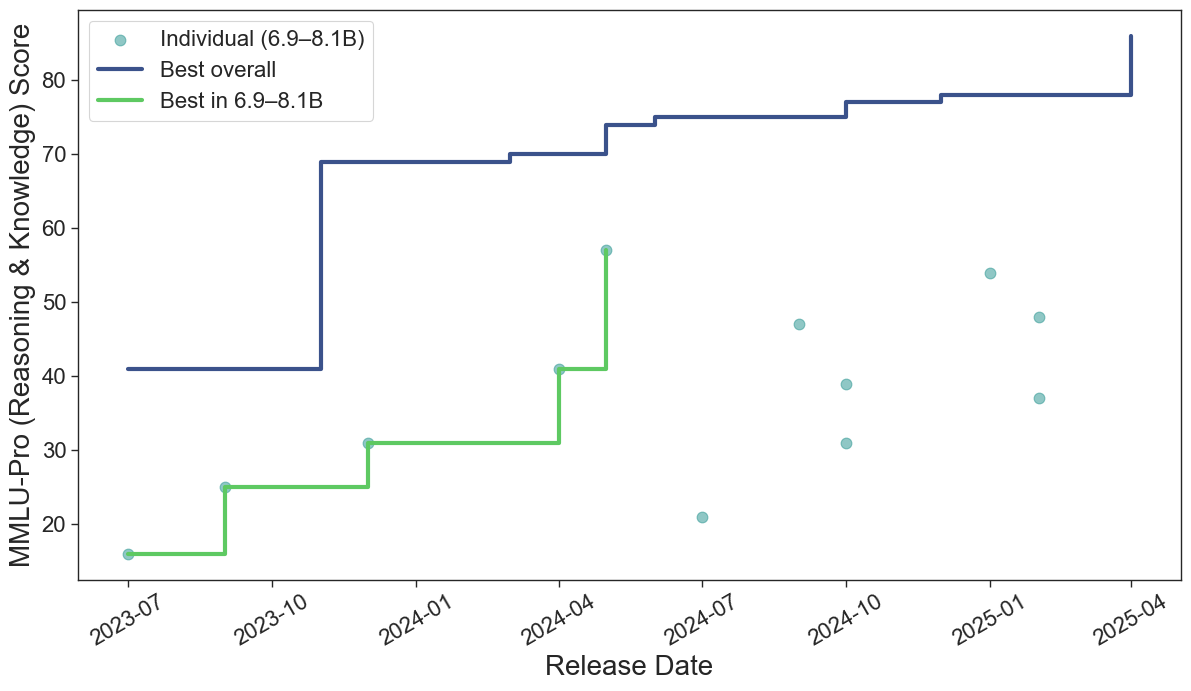

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/2800261252.py:102: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  plt.tight_layout()
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


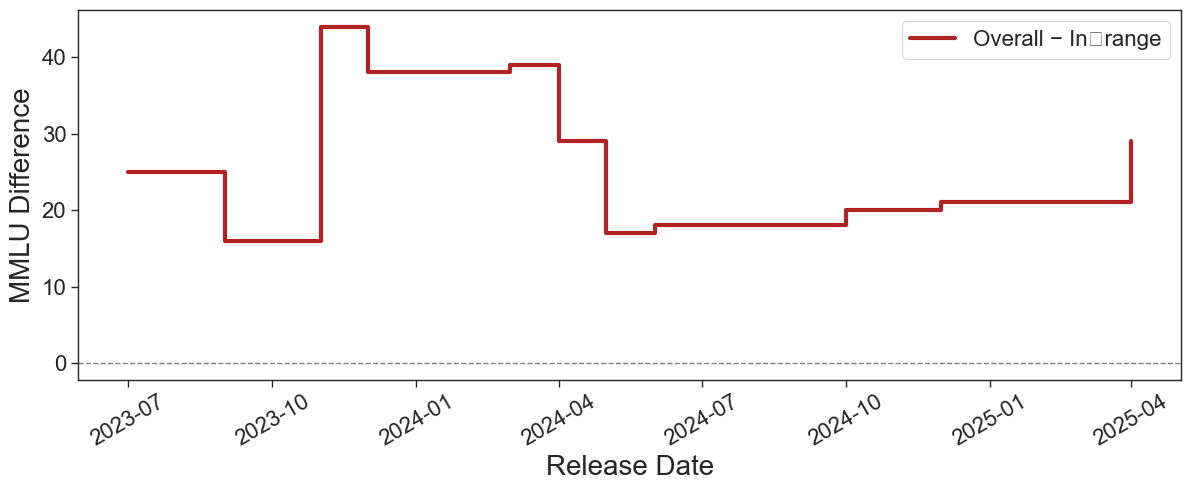

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Styling ────────────────────────────────────────────────────────────────────
sns.set_style("ticks")
sns.set_context("paper")
default_fontsize = 20
colors = sns.color_palette("viridis", n_colors=3)

# ─── User Parameters ───────────────────────────────────────────────────────────
benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
lower_param = 6.9   # billions
upper_param = 8.1  # billions

# ─── Load & Clean ───────────────────────────────────────────────────────────────
df = pd.read_csv('Datasets/art_analysis_scrape.csv')
df['Release Date']    = pd.to_datetime(df['Release Date'])
df['Parameter Count'] = pd.to_numeric(df['Parameter Count'], errors='coerce')
df = df[df[benchmark_feature].notna()]

# strip “%” and convert
if df[benchmark_feature].dtype == 'object':
    df[benchmark_feature] = (
        df[benchmark_feature].str.rstrip('%').astype(float)
    )
else:
    df[benchmark_feature] = df[benchmark_feature].astype(float)

df = df.sort_values('Release Date')

# ─── Build the “best so far” curves ──────────────────────────────────────────────
# 1) overall
df_all = df.copy()
df_all['Best_MMLU_So_Far'] = df_all[benchmark_feature].cummax()
best_overall = (
    df_all[['Release Date','Best_MMLU_So_Far']]
     .drop_duplicates(subset='Best_MMLU_So_Far')
     .set_index('Release Date')['Best_MMLU_So_Far']
)
# drop duplicate dates if any
best_overall = best_overall[~best_overall.index.duplicated(keep='first')]

# 2) in‐range
in_range = df[
    (df['Parameter Count'] >= lower_param) &
    (df['Parameter Count'] <= upper_param)
].sort_values('Release Date')
in_range['Best_MMLU_In_Range'] = in_range[benchmark_feature].cummax()
best_in_range = (
    in_range[['Release Date','Best_MMLU_In_Range']]
     .drop_duplicates(subset='Best_MMLU_In_Range')
     .set_index('Release Date')['Best_MMLU_In_Range']
)
best_in_range = best_in_range[~best_in_range.index.duplicated(keep='first')]

# ─── Plot raw & step‐curves ─────────────────────────────────────────────────────
plt.figure(figsize=(12,7))
plt.scatter(in_range['Release Date'], in_range[benchmark_feature],
            alpha=0.5, s=60, color=colors[1],
            label=f'Individual ({lower_param}–{upper_param}B)')
plt.step(best_overall.index, best_overall.values, where='post',
         color=colors[0], linewidth=3, label='Best overall')
plt.step(best_in_range.index, best_in_range.values, where='post',
         color=colors[2], linewidth=3, label=f'Best in {lower_param}–{upper_param}B')

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

# ─── Build difference curve ────────────────────────────────────────────────────
# only start once both series exist
start = max(best_overall.index.min(), best_in_range.index.min())

# union of two DatetimeIndexes, guaranteed unique & sorted
all_dates = (
    best_overall.index[best_overall.index >= start]
      .union(best_in_range.index[best_in_range.index >= start])
)

# forward‐fill each onto that shared timeline
overall_filled = best_overall.reindex(all_dates, method='ffill')
range_filled   = best_in_range.reindex(all_dates, method='ffill')
diff_curve     = overall_filled - range_filled

# ─── Plot the difference ───────────────────────────────────────────────────────
plt.figure(figsize=(12,5))
plt.step(all_dates, diff_curve.values, where='post',
         color='firebrick', linewidth=3, label='Overall − In‐range')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel('MMLU Difference', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

# Joint Plot Of Both Curves

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/1306773340.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


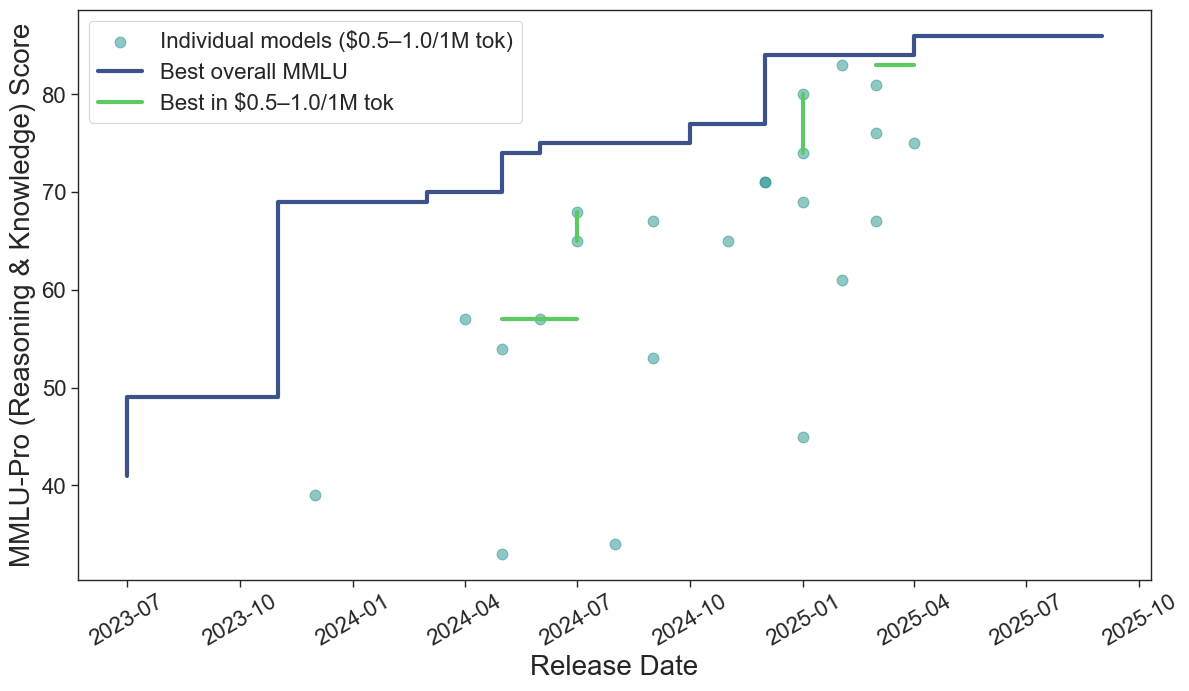

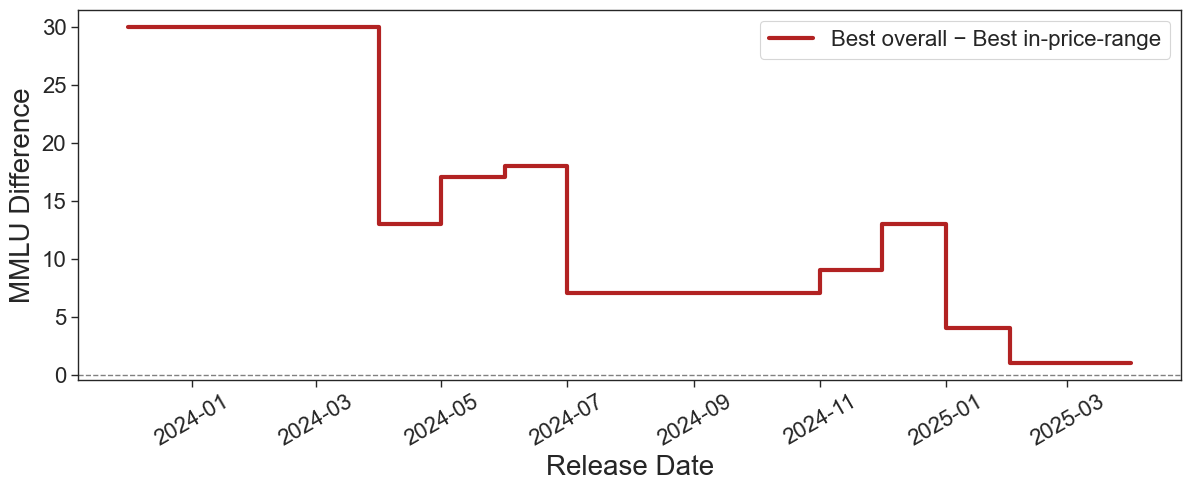

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Styling ───────────────────────────────────────────────────────────────────
sns.set_style("ticks")
sns.set_context("paper")
F = dict(fontsize=20)
colors = sns.color_palette("viridis", n_colors=3)

# ─── User parameters ───────────────────────────────────────────────────────────
# benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
lower_price = 0.5   # USD per 1M tokens
upper_price = 1.0   # USD per 1M tokens
price_col = 'Output Price\nUSD/1M Tokens'

# ─── Load & clean ───────────────────────────────────────────────────────────────
df = pd.read_csv('Datasets/art_analysis_scrape.csv')
df['Release Date'] = pd.to_datetime(df['Release Date'])

# strip “$” and commas from the price column, convert to float
df[price_col] = (
    df[price_col].astype(str)
                .str.replace(r'[\$,]', '', regex=True)
                .astype(float)
)

# drop anything missing MMLU or Release Date
df = df[df[benchmark_feature].notna()]

# strip a trailing “%” if present, convert to float
if df[benchmark_feature].dtype == object:
    df[benchmark_feature] = (
        df[benchmark_feature].str.rstrip('%').astype(float)
    )
else:
    df[benchmark_feature] = df[benchmark_feature].astype(float)

# sort in time
df = df.sort_values('Release Date').reset_index(drop=True)

# ─── Compute both cummax series on the same timeline ────────────────────────────
# overall best
df['Best_overall'] = df[benchmark_feature].cummax()

# mark only the price‐in‐range values, NaN elsewhere
mask = df[price_col].between(lower_price, upper_price)
df['MMLU_in_price'] = df[benchmark_feature].where(mask, np.nan)

# best so far within the price range
df['Best_in_price'] = df['MMLU_in_price'].cummax()

# ─── First figure: scatter + two step‐curves ────────────────────────────────────
plt.figure(figsize=(12,7))
# scatter only the raw 0.5–1 $/1M-tok models
plt.scatter(
    df.loc[mask, 'Release Date'],
    df.loc[mask, benchmark_feature],
    alpha=0.5, s=60, color=colors[1],
    label=f'Individual models (${lower_price}–{upper_price}/1M tok)'
)

# use the full df index for both step curves
plt.step(
    df['Release Date'],
    df['Best_overall'],
    where='post', color=colors[0], linewidth=3,
    label='Best overall MMLU'
)

plt.step(
    df['Release Date'],
    df['Best_in_price'],
    where='post', color=colors[2], linewidth=3,
    label=f'Best in ${lower_price}–{upper_price}/1M tok'
)

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

# ─── Second figure: difference curve ────────────────────────────────────────────
# drop rows before the first in‐range model (where Best_in_price is still NaN)
df_diff = df.dropna(subset=['Best_in_price']).copy()
df_diff['Difference'] = df_diff['Best_overall'] - df_diff['Best_in_price']

plt.figure(figsize=(12,5))
plt.step(df_diff['Release Date'], df_diff['Difference'], where='post',
         color='firebrick', linewidth=3,
         label='Best overall − Best in-price-range')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', **F)
plt.ylabel('MMLU Difference', **F)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

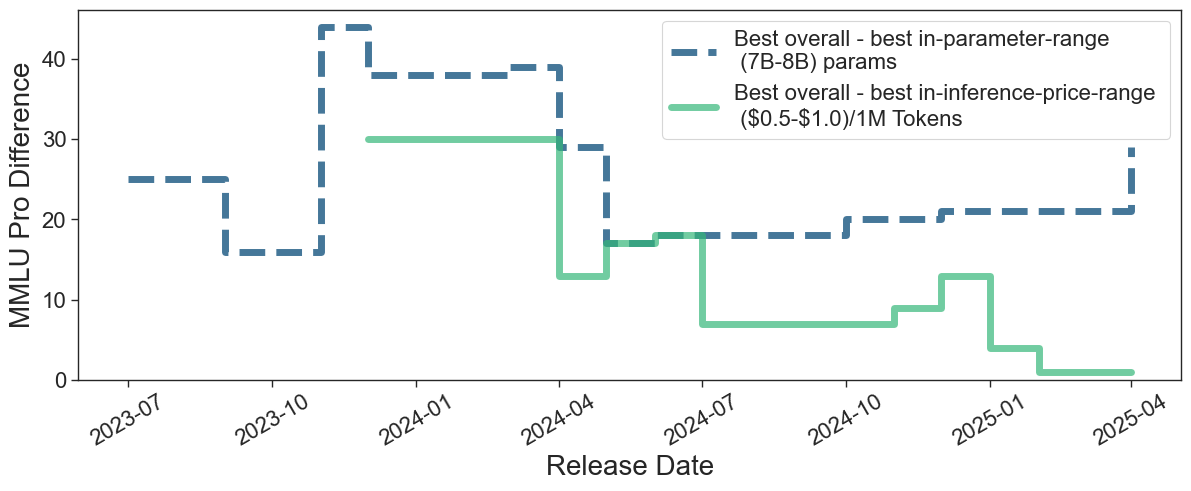

In [17]:
plt.figure(figsize=(12,5))

sns.set_style("ticks")
sns.set_context("paper")
F = dict(fontsize=20)
colors = sns.color_palette("viridis", n_colors=2)


plt.step(all_dates, diff_curve.values, where='post', linewidth=5, alpha= 0.9, label='Best overall - best in-parameter-range \n (7B-8B) params', color=colors[0], linestyle="--")
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel('MMLU Difference', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)


#infernce differnet
plt.step(df_diff['Release Date'], df_diff['Difference'], where='post', linewidth=5, alpha=0.7,
         label='Best overall - best in-inference-price-range \n (\$0.5-\$1.0)/1M Tokens', color=colors[1])
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', **F)
plt.ylabel('MMLU Pro Difference', **F)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.ylim(0)
plt.tight_layout()
plt.savefig("Figures/joint_diff_graph.png")

plt.show()

# Chatbot Arena Analysis

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/1731122314.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


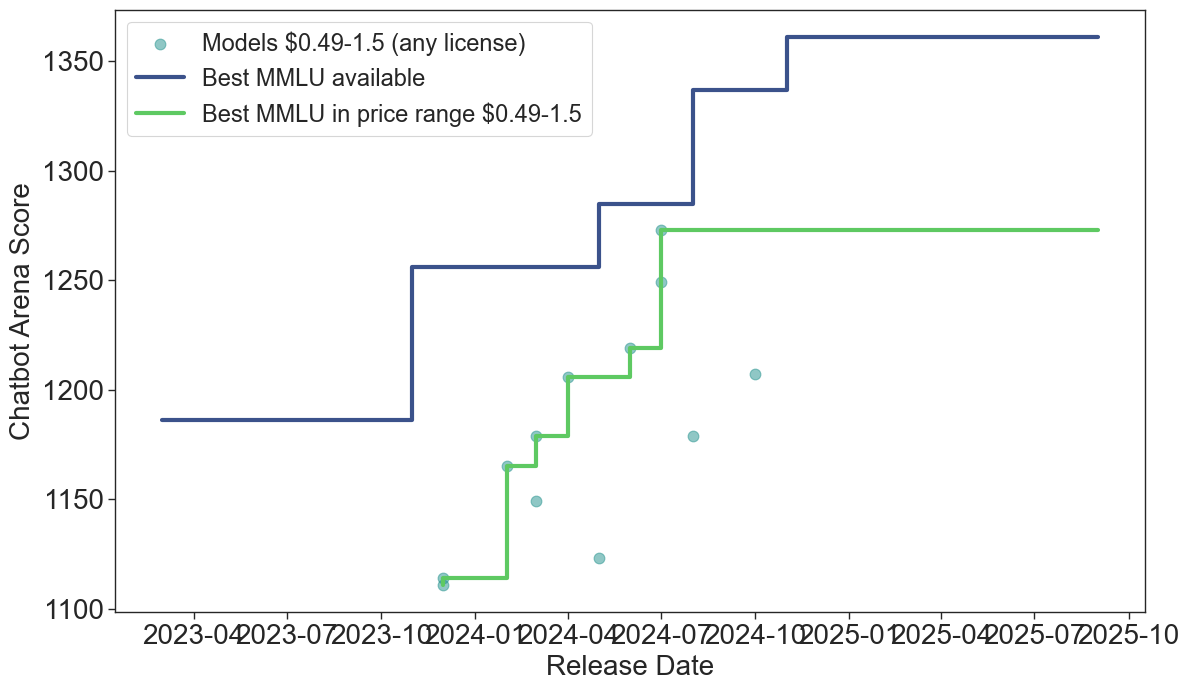

In [18]:
compare_mmlu_to_best_over_time_any_license(0.49, 1.5, benchmark_feature="Chatbot Arena")

compare_mmlu_to_best_over_time_by_param_count(6.9, 8.1, benchmark_feature="Chatbot Arena")

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Further\nAnalysis', 'Release Date', 'Parameter Count #Solid',
       'Parameter Count', 'MOE', 'Source'],
     

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61615/1860885797.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


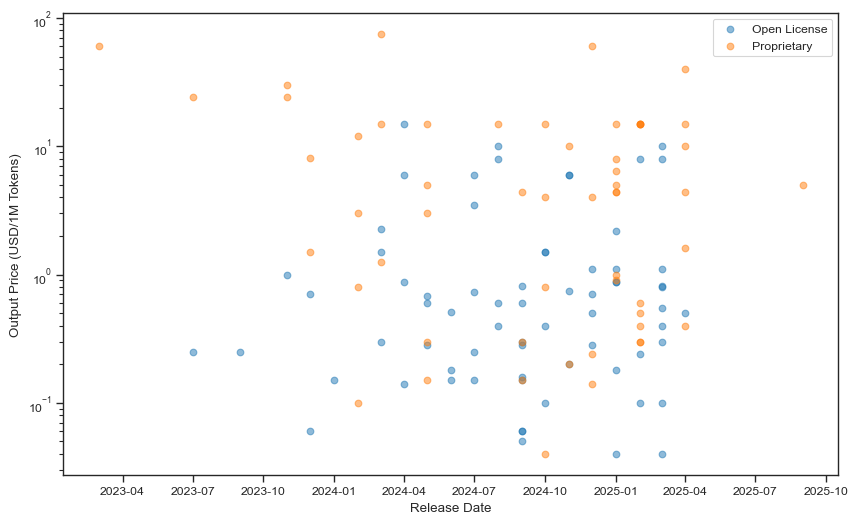

In [9]:

df = pd.read_csv('Datasets/art_analysis_scrape.csv')

#print the first 5 rows of the dataframe
# print(df.head())
print(df.columns)

# Convert 'release_date' to datetime if it's not already
#filter out nan values  

#filter based on 
df = df[df['Output Price\nUSD/1M Tokens'].notna()]
df = df[df['Release Date'].notna()]
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Convert price to float - handle the case where it might not be a string
# First check if the column contains strings
if df['Output Price\nUSD/1M Tokens'].dtype == 'object':
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
else:
    # If it's already numeric, just ensure it's float type
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].astype(float)

#collect output price for models with open licenses
open_license_df = df[df['License'] == 'Open']
proprietary_df = df[df['License'] == 'Proprietary']

#plot output price for open and proprietary models
plt.figure(figsize=(10, 6))
plt.scatter(open_license_df['Release Date'], open_license_df['Output Price\nUSD/1M Tokens'], alpha=0.5, label='Open License')
plt.scatter(proprietary_df['Release Date'], proprietary_df['Output Price\nUSD/1M Tokens'], alpha=0.5, label='Proprietary')
plt.xlabel('Release Date')
plt.ylabel('Output Price (USD/1M Tokens)')
plt.yscale('log')
plt.legend()
# Plot output price vs release date
# plt.figure(figsize=(10, 6))
# plt.scatter(df['Date'], df['Output Price\nUSD/1M Tokens'], alpha=0.5)
# plt.xlabel('Release Date')
# plt.ylabel('Output Price (USD/1M Tokens)')

In [10]:
# interesting questions how is the price gap betwene open and proprietar models changing over time?
# how fast are open model prices declining with time?
# how fast are proprietary modle prices declinging with time? normalized by benchmark score
# how are context windows changing over time? between open and proprietary models
# markup differenc for fixed mmlu score 


In [5]:
print(df['Context\nWindow'])

NameError: name 'df' is not defined

# Trends in Context Length Over Time

                          Model  Creator      License Context\nWindow  \
0                o4-mini (high)      NaN  Proprietary            200k   
1        Gemini 2.5 Pro Preview      NaN  Proprietary              1m   
2  Grok 3 mini Reasoning (high)      NaN  Proprietary              1m   
3                o3-mini (high)      NaN  Proprietary            200k   
4                       o3-mini      NaN  Proprietary            200k   

   Artificial Analysis\nIntelligence Index MMLU-Pro (Reasoning & Knowledge)  \
0                                     70.0                              83%   
1                                     68.0                              86%   
2                                     67.0                              83%   
3                                     66.0                              80%   
4                                     63.0                              79%   

  GPQA Diamond (Scientific Reasoning)  \
0                                 78%   
1   

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/642291491.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


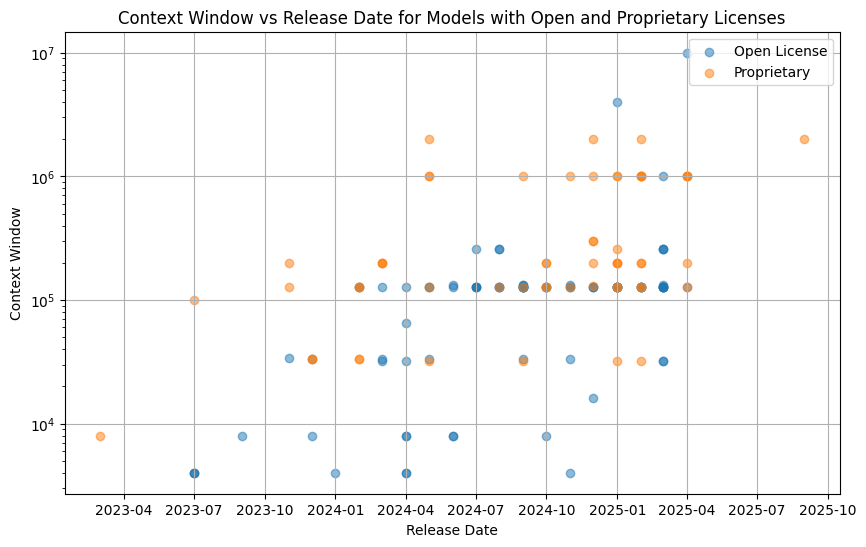

In [10]:
df = pd.read_csv('Datasets/art_analysis_scrape.csv')

#print the first 5 rows of the dataframe
print(df.head())
df.columns

# Convert 'release_date' to datetime if it's not already
#filter out nan values  

#filter based on 
df = df[df['Context\nWindow'].notna()]
df = df[df['Release Date'].notna()]
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Convert context window to float - handle the case where it might not be a string
# First check if the column contains strings
if df['Context\nWindow'].dtype == 'object':
    # Replace 'k' and 'm' suffixes with their numeric equivalents
    df['Context\nWindow'] = df['Context\nWindow'].str.replace('k', '000').str.replace('m', '000000')
    df['Context\nWindow'] = df['Context\nWindow'].str.replace('$', '').astype(float)
else:
    # If it's already numeric, just ensure it's float type
    df['Context\nWindow'] = df['Context\nWindow'].astype(float)

#collect output price for models with open licenses
open_license_df = df[df['License'] == 'Open']
proprietary_df = df[df['License'] == 'Proprietary']

#plot output price for open and proprietary models
plt.figure(figsize=(10, 6))
plt.scatter(open_license_df['Release Date'], open_license_df['Context\nWindow'], alpha=0.5, label='Open License')
plt.scatter(proprietary_df['Release Date'], proprietary_df['Context\nWindow'], alpha=0.5, label='Proprietary')
plt.xlabel('Release Date')
plt.ylabel('Context Window')
plt.title('Context Window vs Release Date for Models with Open and Proprietary Licenses')
plt.grid(True)
plt.yscale('log')
plt.legend()
# Plot output price vs release date
# plt.figure(figsize=(10, 6))
# plt.scatter(df['Date'], df['Output Price\nUSD/1M Tokens'], alpha=0.5)
# plt.xlabel('Release Date')
# plt.ylabel('Output Price (USD/1M Tokens)')

# Context Length at Fixed Costs

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3694101565.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


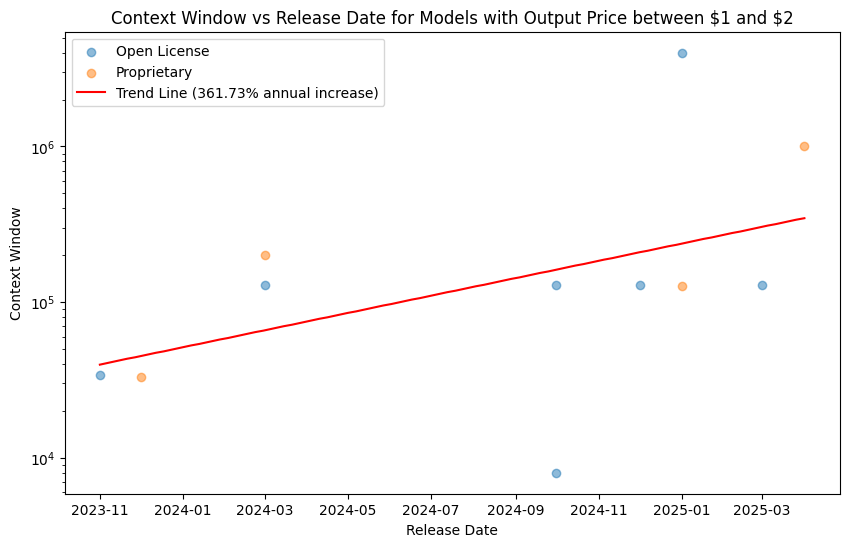

In [15]:
df = pd.read_csv('Datasets/art_analysis_scrape.csv')
mincost = 1
maxcost = 2
df = df[df['Context\nWindow'].notna()]
df = df[df['Release Date'].notna()]
df['Release Date'] = pd.to_datetime(df['Release Date'])

#filter based on cost

df = df[df['Output Price\nUSD/1M Tokens'].notna()]
#convert$ to float
df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
df = df[df['Output Price\nUSD/1M Tokens'] >= mincost]
df = df[df['Output Price\nUSD/1M Tokens'] <= maxcost]

# Convert context window to float - handle the case where it might not be a string
# First check if the column contains strings
if df['Context\nWindow'].dtype == 'object':
    # Replace 'k' and 'm' suffixes with their numeric equivalents
    df['Context\nWindow'] = df['Context\nWindow'].str.replace('k', '000').str.replace('m', '000000')
    df['Context\nWindow'] = df['Context\nWindow'].str.replace('$', '').astype(float)
else:
    # If it's already numeric, just ensure it's float type
    df['Context\nWindow'] = df['Context\nWindow'].astype(float)

#collect output price for models with open licenses
open_license_df = df[df['License'] == 'Open']
proprietary_df = df[df['License'] == 'Proprietary']

# Convert dates to numeric for regression
df['Date_Numeric'] = pd.to_datetime(df['Release Date']).map(datetime.toordinal)

# Prepare data for regression (using log of context window)
X = df['Date_Numeric'].values.reshape(-1, 1)
y = np.log10(df['Context\nWindow'].values)

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Generate points for the regression line
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Convert back to datetime for plotting
x_dates = [datetime.fromordinal(int(x[0])) for x in x_range]

# Calculate percent increase per day
daily_percent_increase = (10**(model.coef_[0]) - 1) * 100
# Calculate annual percent increase (compounded daily)
annual_percent_increase = ((10**(model.coef_[0]))**365 - 1) * 100

#plot output price for open and proprietary models
plt.figure(figsize=(10, 6))
plt.scatter(open_license_df['Release Date'], open_license_df['Context\nWindow'], alpha=0.5, label='Open License')
plt.scatter(proprietary_df['Release Date'], proprietary_df['Context\nWindow'], alpha=0.5, label='Proprietary')
# Plot the regression line
plt.plot(x_dates, 10**y_pred, 'r-', label=f'Trend Line ({annual_percent_increase:.2f}% annual increase)')
plt.xlabel('Release Date')
plt.ylabel('Context Window')
plt.title(f'Context Window vs Release Date for Models with Output Price between \${mincost} and \${maxcost}')
plt.yscale('log')
plt.legend()


In [16]:
# print(df['GPQA Diamond (Scientific Reasoning)'])
# #turn percentage to float
# df['GPQA Diamond (Scientific Reasoning)'] = df['GPQA Diamond (Scientific Reasoning)'].str.replace('%', '').astype(float)

# print(df['GPQA Diamond (Scientific Reasoning)'])

# General Trend for Models

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/1392026484.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


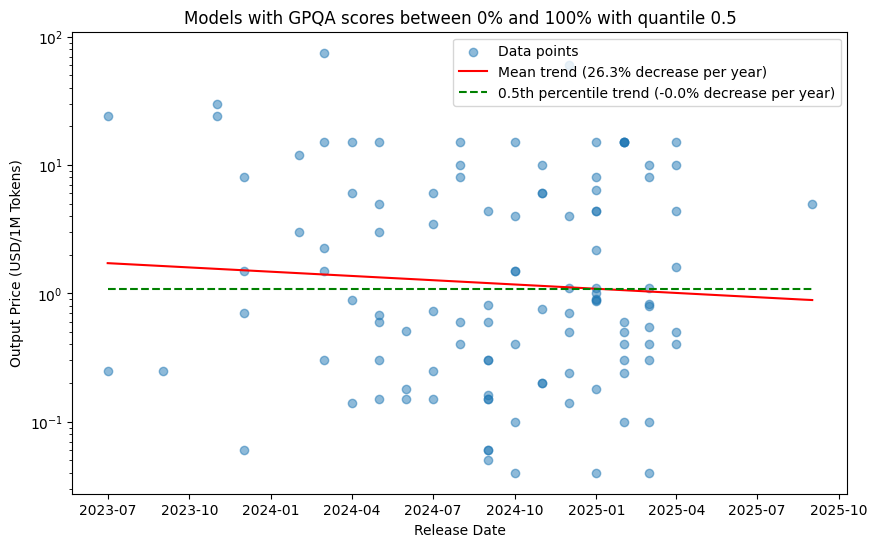

In [17]:
# graph trend in price for models with GPQA in certain range

df = pd.read_csv('Datasets/art_analysis_scrape.csv')
df['Release Date'] = pd.to_datetime(df['Release Date'])
df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
upper_level_gp =100
lower_level_gp = 0
quantile = 0.5
benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'

# Drop nan values
df = df[df[benchmark_feature].notna()]
df = df[df['Release Date'].notna()]

# Convert GPQA values to float - handle the case where values are already numeric
# First check if the values are strings or already numeric
if df[benchmark_feature].dtype == 'object':
    # If they're strings, remove the % sign and convert
    df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
else:
    # If they're already numeric, just ensure they're float type
    df[benchmark_feature] = df[benchmark_feature].astype(float)

# Filter based on GPQA - fix the logical operator (use 'and' or '&' with parentheses)
gpqa_df = df[(df[benchmark_feature] >= lower_level_gp) & 
             (df[benchmark_feature] <= upper_level_gp)]

# Convert release date to numeric for regression


# Convert dates to numeric format for regression
gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)

# Take log of prices for linear regression, handling zeros and infinities
output_prices = gpqa_df['Output Price\nUSD/1M Tokens']
# Filter out zeros and negative values before taking log
valid_prices = output_prices[output_prices > 0]
gpqa_df_filtered = gpqa_df[output_prices > 0]
log_prices = np.log(valid_prices)

# Check for infinite values and remove them
mask = np.isfinite(log_prices)
gpqa_df_filtered = gpqa_df_filtered[mask]
log_prices = log_prices[mask]

# Fit linear regression model
X = gpqa_df_filtered['Date_Numeric'].values.reshape(-1, 1)
y = log_prices.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Calculate percent decrease per year
# The coefficient represents the change in log price per day
daily_rate = model.coef_[0][0]
# Convert to yearly rate
yearly_rate = daily_rate * 365
# Convert log change to percent change: e^yearly_rate - 1
percent_change_per_year = (np.exp(yearly_rate) - 1) * 100
# Since we expect a decrease, make it positive for reporting
percent_decrease_per_year = -percent_change_per_year

# Generate prediction line
date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
log_price_pred = model.predict(date_range)
price_pred = np.exp(log_price_pred)

# Fit quantile regression for bottom 20 percent
# X_quant = gpqa_df_filtered['Date_Numeric'].values
# y_quant = log_prices.values
# # Add constant properly using numpy instead of sm.add_constant
# X_quant_with_const = np.column_stack((np.ones(len(X_quant)), X_quant))
# quant_model = QuantReg(y_quant, X_quant_with_const)
# quant_result = quant_model.fit(q=quantile)

# ... existing code ...
# Fit quantile regression
X_quant = gpqa_df_filtered['Date_Numeric'].values.reshape(-1, 1)  # Reshape like we did for linear regression
y_quant = log_prices.values.reshape(-1, 1)  # Reshape to match

# Create the quantile regression model
quant_model = QuantReg(y_quant, X_quant)
quant_result = quant_model.fit(q=quantile)

# Generate quantile regression prediction line
log_price_quant_pred = quant_result.predict(date_range)  # Use date_range directly
price_quant_pred = np.exp(log_price_quant_pred)

# Calculate percent decrease per year for quantile regression
daily_rate_quant = quant_result.params[0]  # Changed from params[1] to params[0]
yearly_rate_quant = daily_rate_quant * 365
percent_change_per_year_quant = (np.exp(yearly_rate_quant) - 1) * 100
percent_decrease_per_year_quant = -percent_change_per_year_quant

# Convert numeric dates back to datetime for plotting
date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]

# Plot output price vs release date for gpqa_df with trend line
plt.figure(figsize=(10, 6))
plt.scatter(gpqa_df_filtered['Release Date'], gpqa_df_filtered['Output Price\nUSD/1M Tokens'], alpha=0.5, label='Data points')
plt.plot(date_range_dt, price_pred, 'r-', label=f'Mean trend ({percent_decrease_per_year:.1f}% decrease per year)')
plt.plot(date_range_dt, price_quant_pred, 'g--', label=f'{quantile}th percentile trend ({percent_decrease_per_year_quant:.1f}% decrease per year)')
plt.xlabel('Release Date')
plt.ylabel('Output Price (USD/1M Tokens)')
plt.yscale('log')
plt.title(f'Models with GPQA scores between {lower_level_gp}% and {upper_level_gp}% with quantile {quantile}')
plt.legend()

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/1232167846.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/1232167846.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

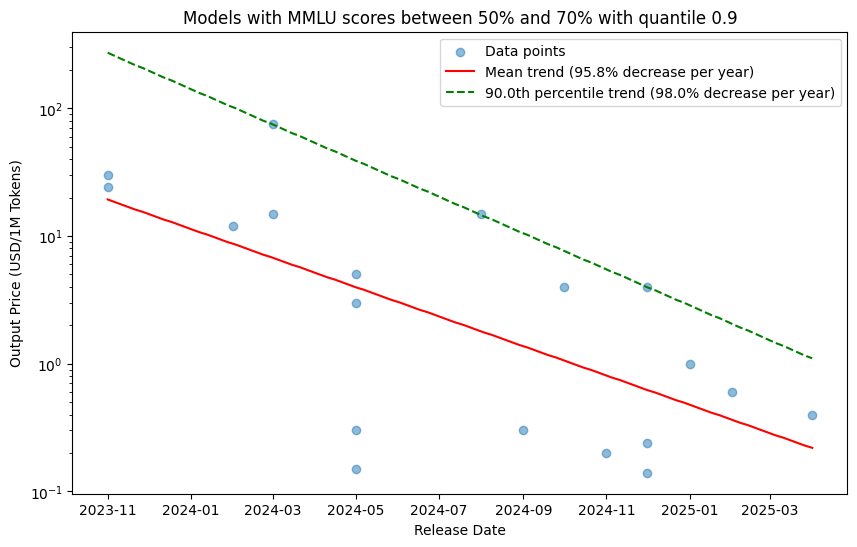

In [18]:
# graph trend in price for models with GPQA in certain range

df = pd.read_csv('Datasets/art_analysis_scrape.csv')
df['Release Date'] = pd.to_datetime(df['Release Date'])
df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
upper_level_gp = 70
lower_level_gp = 50
quantile = 0.9
benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
type = 'Proprietary'
# type = 'Open'
df = df[df['License'] == type]

# Drop nan values
df = df[df[benchmark_feature].notna()]
df = df[df['Release Date'].notna()]

# Convert GPQA values to float - handle the case where values are already numeric
# First check if the values are strings or already numeric
if df[benchmark_feature].dtype == 'object':
    # If they're strings, remove the % sign and convert
    df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
else:
    # If they're already numeric, just ensure they're float type
    df[benchmark_feature] = df[benchmark_feature].astype(float)

# Filter based on GPQA - fix the logical operator (use 'and' or '&' with parentheses)
gpqa_df = df[(df[benchmark_feature] >= lower_level_gp) & 
             (df[benchmark_feature] <= upper_level_gp)]

# Convert dates to numeric format for regression
gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)

# Take log of prices for linear regression, handling zeros and infinities
output_prices = gpqa_df['Output Price\nUSD/1M Tokens']
# Filter out zeros and negative values before taking log
valid_prices = output_prices[output_prices > 0]
gpqa_df_filtered = gpqa_df[output_prices > 0]
log_prices = np.log(valid_prices)

# Check for infinite values and remove them
mask = np.isfinite(log_prices)
gpqa_df_filtered = gpqa_df_filtered[mask]
log_prices = log_prices[mask]

# Fit linear regression model
X = gpqa_df_filtered['Date_Numeric'].values.reshape(-1, 1)
y = log_prices.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Calculate percent decrease per year
# The coefficient represents the change in log price per day
daily_rate = model.coef_[0][0]
# Convert to yearly rate
yearly_rate = daily_rate * 365
# Convert log change to percent change: e^yearly_rate - 1
percent_change_per_year = (np.exp(yearly_rate) - 1) * 100
# Since we expect a decrease, make it positive for reporting
percent_decrease_per_year = -percent_change_per_year

# Generate prediction line
date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
log_price_pred = model.predict(date_range)
price_pred = np.exp(log_price_pred)

# Fit quantile regression using sklearn
from sklearn.linear_model import QuantileRegressor

# Create and fit the quantile regression model
quant_model = QuantileRegressor(quantile=quantile, alpha=0)
quant_model.fit(X, y)  # Use the same X and y as linear regression

# Generate quantile regression prediction line
log_price_quant_pred = quant_model.predict(date_range)
price_quant_pred = np.exp(log_price_quant_pred)

# Calculate percent decrease per year for quantile regression
daily_rate_quant = quant_model.coef_[0]  # Get coefficient from sklearn model
yearly_rate_quant = daily_rate_quant * 365
percent_change_per_year_quant = (np.exp(yearly_rate_quant) - 1) * 100
percent_decrease_per_year_quant = -percent_change_per_year_quant

# Convert numeric dates back to datetime for plotting
date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]

# Plot output price vs release date for gpqa_df with trend line
plt.figure(figsize=(10, 6))
plt.scatter(gpqa_df_filtered['Release Date'], gpqa_df_filtered['Output Price\nUSD/1M Tokens'], alpha=0.5, label='Data points')
plt.plot(date_range_dt, price_pred, 'r-', label=f'Mean trend ({percent_decrease_per_year:.1f}% decrease per year)')
plt.plot(date_range_dt, price_quant_pred, 'g--', label=f'{quantile*100}th percentile trend ({percent_decrease_per_year_quant:.1f}% decrease per year)')
plt.xlabel('Release Date')
plt.ylabel('Output Price (USD/1M Tokens)')
plt.yscale('log')
plt.title(f'Models with MMLU scores between {lower_level_gp}% and {upper_level_gp}% with quantile {quantile}')
plt.legend()

# Plotting Function

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

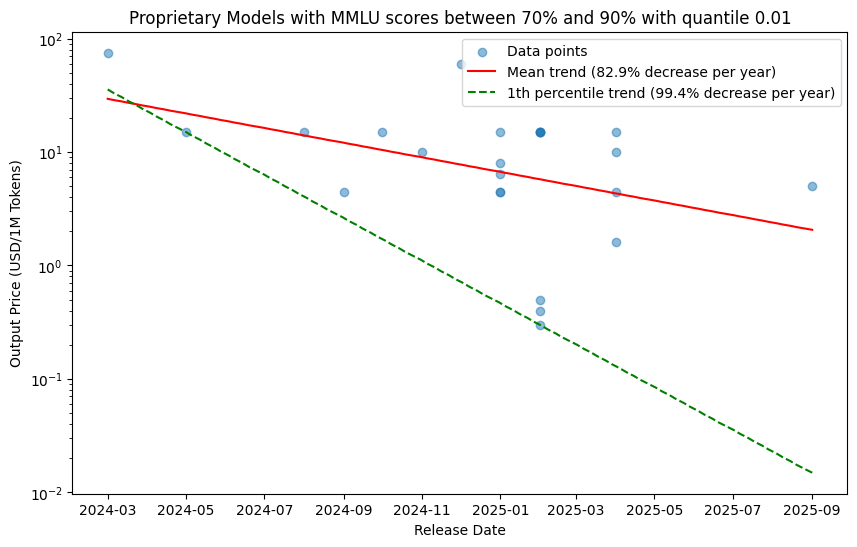

In [20]:


def plot_price_trends(upper_level_gp, lower_level_gp, quantile=None, type='Proprietary'):
    """
    Plots price trends for models with MMLU-Pro (Reasoning & Knowledge) scores
    between lower_level_gp and upper_level_gp. Filters by license type.
    Optional quantile regression can be included by specifying a quantile value.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
    from sklearn.linear_model import LinearRegression, QuantileRegressor

    df = pd.read_csv('Datasets/art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
    benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    df = df[df['License'] == type]

    # Drop nan values
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]

    # Convert GPQA values to float - handle the case where values are already numeric
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)

    # Filter based on GPQA
    gpqa_df = df[(df[benchmark_feature] >= lower_level_gp) & 
                 (df[benchmark_feature] <= upper_level_gp)]

    # Convert dates to numeric format for regression
    gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)

    # Take log of prices for linear regression, handling zeros and infinities
    output_prices = gpqa_df['Output Price\nUSD/1M Tokens']
    valid_prices = output_prices[output_prices > 0]
    gpqa_df_filtered = gpqa_df[output_prices > 0]
    log_prices = np.log(valid_prices)

    # Check for infinite values and remove them
    mask = np.isfinite(log_prices)
    gpqa_df_filtered = gpqa_df_filtered[mask]
    log_prices = log_prices[mask]

    # Fit linear regression model
    X = gpqa_df_filtered['Date_Numeric'].values.reshape(-1, 1)
    y = log_prices.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)

    # Calculate percent decrease per year
    daily_rate = model.coef_[0][0]
    yearly_rate = daily_rate * 365
    percent_change_per_year = (np.exp(yearly_rate) - 1) * 100
    percent_decrease_per_year = -percent_change_per_year

    # Generate prediction line
    date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    log_price_pred = model.predict(date_range)
    price_pred = np.exp(log_price_pred)

    # Convert numeric dates back to datetime for plotting
    date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]

    # Plot output price vs release date for gpqa_df with trend line
    plt.figure(figsize=(10, 6))
    plt.scatter(gpqa_df_filtered['Release Date'], gpqa_df_filtered['Output Price\nUSD/1M Tokens'], alpha=0.5, label='Data points')
    plt.plot(date_range_dt, price_pred, 'r-', label=f'Mean trend ({percent_decrease_per_year:.1f}% decrease per year)')
    
    # Add quantile regression if quantile is specified
    if quantile is not None:
        # Fit quantile regression using sklearn
        quant_model = QuantileRegressor(quantile=quantile, alpha=0)
        quant_model.fit(X, y)
        log_price_quant_pred = quant_model.predict(date_range)
        price_quant_pred = np.exp(log_price_quant_pred)

        # Calculate percent decrease per year for quantile regression
        daily_rate_quant = quant_model.coef_[0]
        yearly_rate_quant = daily_rate_quant * 365
        percent_change_per_year_quant = (np.exp(yearly_rate_quant) - 1) * 100
        percent_decrease_per_year_quant = -percent_change_per_year_quant
        
        plt.plot(date_range_dt, price_quant_pred, 'g--', label=f'{quantile*100:.0f}th percentile trend ({percent_decrease_per_year_quant:.1f}% decrease per year)')
        plt.title(f'{type} Models with MMLU scores between {lower_level_gp}% and {upper_level_gp}% with quantile {quantile}')
    else:
        plt.title(f'Models with MMLU scores between {lower_level_gp}% and {upper_level_gp}%')
    
    plt.xlabel('Release Date')
    plt.ylabel('Output Price (USD/1M Tokens)')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Example usage:
plot_price_trends(90, 70, quantile=0.01, type='Proprietary')

# Analysis Of All Trends

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

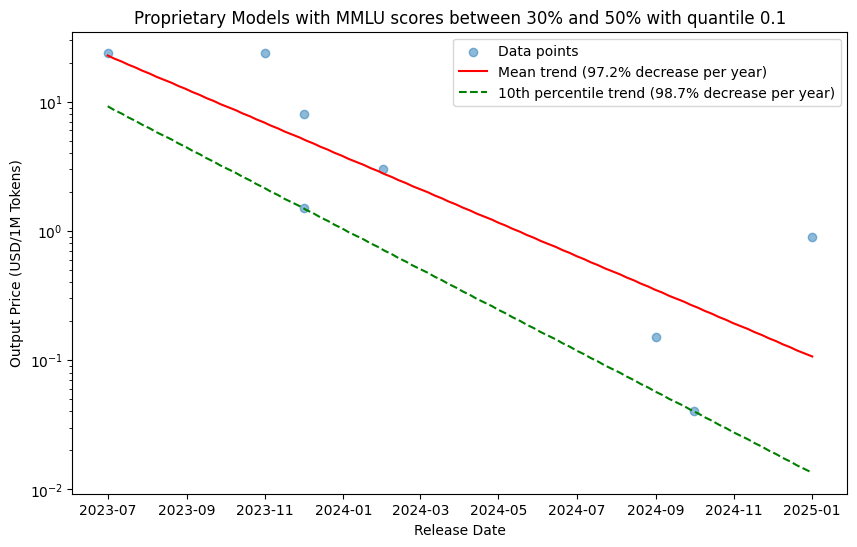

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

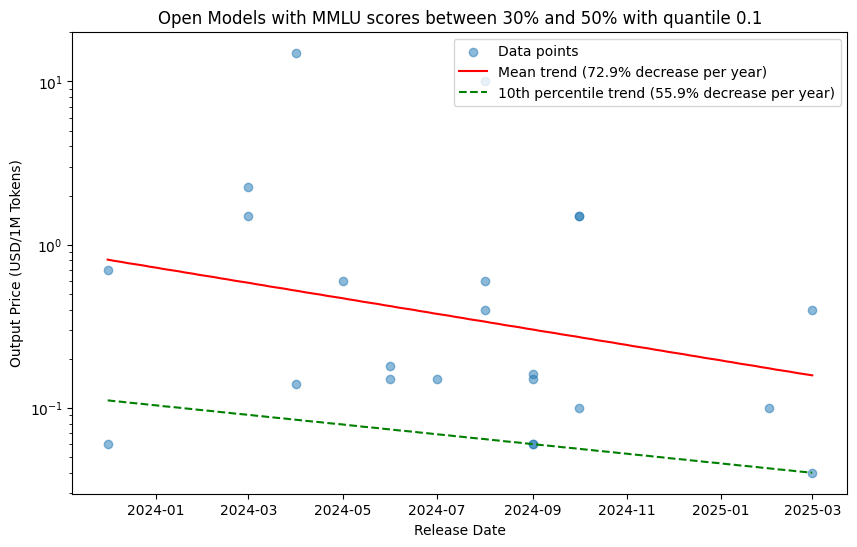

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

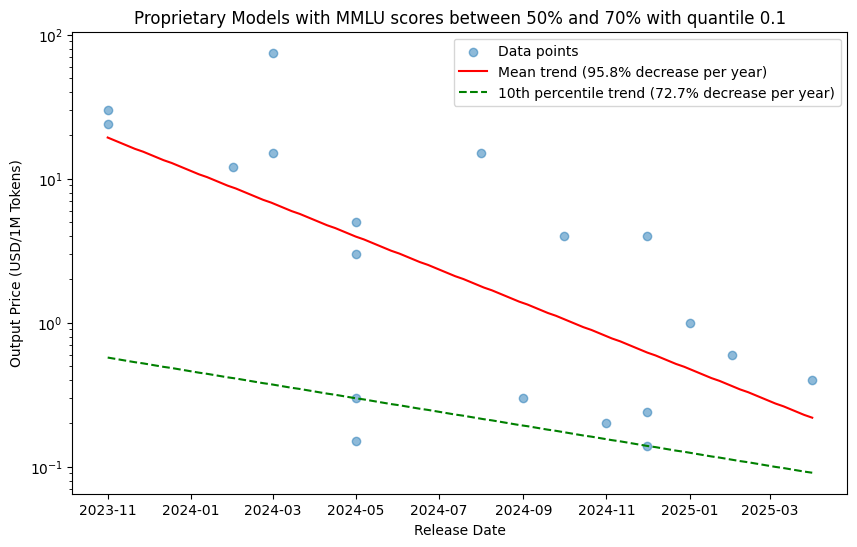

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

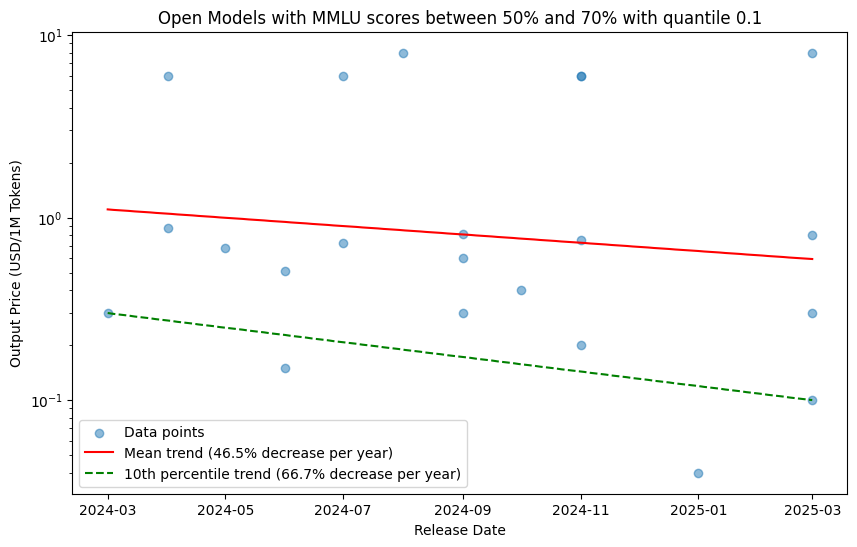

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

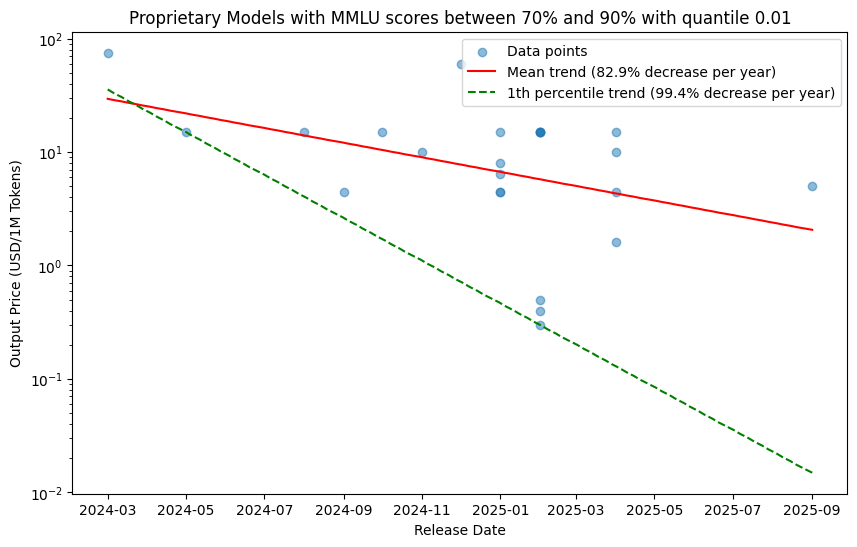

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3311388337.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

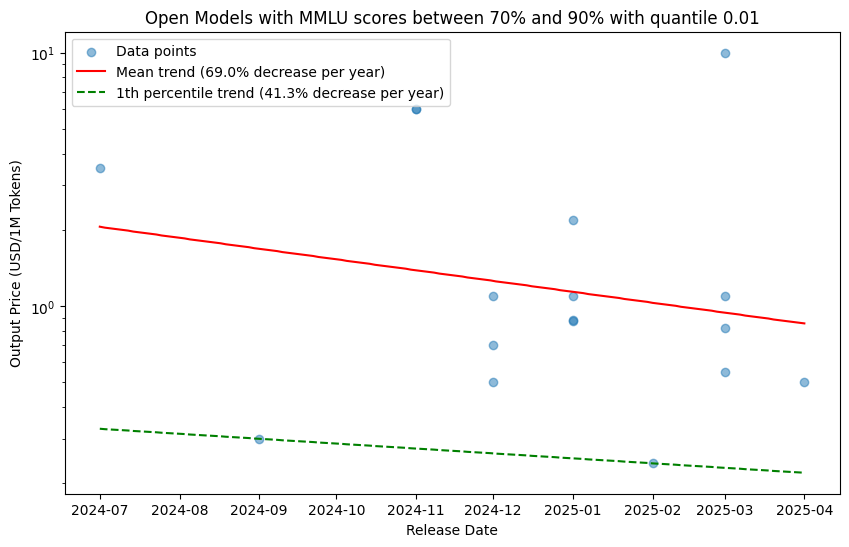

In [21]:

plot_price_trends(50, 30, quantile=0.1, type='Proprietary')
plot_price_trends(50, 30, quantile=0.1, type='Open')
plot_price_trends(70, 50, quantile=0.1, type='Proprietary')
plot_price_trends(70, 50, quantile=0.1, type='Open')
plot_price_trends(90, 70, quantile=0.01, type='Proprietary')
plot_price_trends(90, 70, quantile=0.01, type='Open')

# Looking at Parameter Count Experiments
- holding quality constant look at param over time
- look at price/param ratio over time, using just open source 
- holding param constant look at quality over time 


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/2506706212.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/2506706212.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_df['Date_Numeric'] = pd.to_datetime(mmlu_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

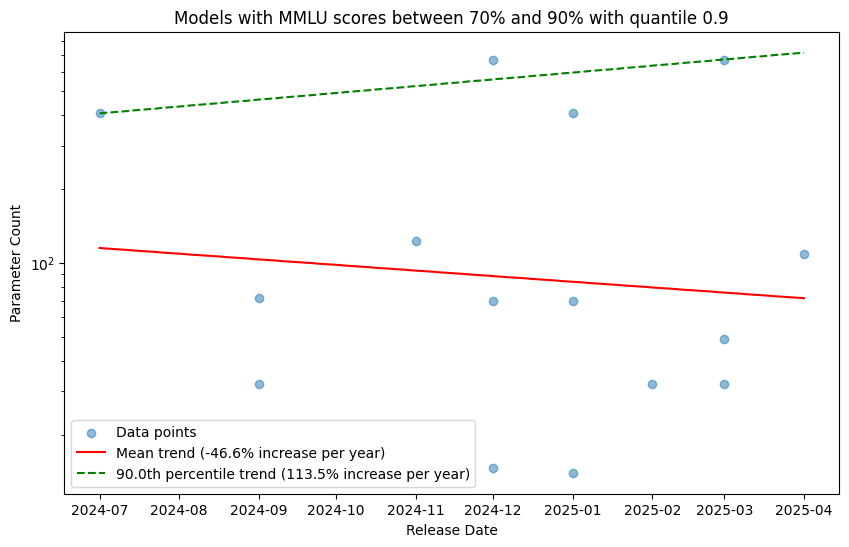

In [22]:
#look at modles with MMLU 70-90 graph parameter count over time 
# graph trend in parameter count for models with MMLU in certain range

df = pd.read_csv('Datasets/art_analysis_scrape.csv')
df['Release Date'] = pd.to_datetime(df['Release Date'])
df['Parameter Count'] = df['Parameter Count'].astype(float)  # Ensure parameter count is numeric
upper_level_gp =90
lower_level_gp = 70
quantile = 0.9
benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
type = 'Open'
# type = 'Open'
df = df[df['License'] == type]

# Drop nan values
df = df[df[benchmark_feature].notna()]
df = df[df['Release Date'].notna()]
df = df[df['Parameter Count'].notna()]  # Ensure parameter count is not NaN

# Convert MMLU values to float - handle the case where values are already numeric
# First check if the values are strings or already numeric
if df[benchmark_feature].dtype == 'object':
    # If they're strings, remove the % sign and convert
    df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
else:
    # If they're already numeric, just ensure they're float type
    df[benchmark_feature] = df[benchmark_feature].astype(float)

# Filter based on MMLU
mmlu_df = df[(df[benchmark_feature] >= lower_level_gp) & 
             (df[benchmark_feature] <= upper_level_gp)]

# Convert dates to numeric format for regression
mmlu_df['Date_Numeric'] = pd.to_datetime(mmlu_df['Release Date']).map(datetime.toordinal)

# Take log of parameter counts for linear regression
param_counts = mmlu_df['Parameter Count']
# Filter out zeros and negative values before taking log
valid_params = param_counts[param_counts > 0]
mmlu_df_filtered = mmlu_df[param_counts > 0]
log_params = np.log(valid_params)

# Check for infinite values and remove them
mask = np.isfinite(log_params)
mmlu_df_filtered = mmlu_df_filtered[mask]
log_params = log_params[mask]

# Fit linear regression model
X = mmlu_df_filtered['Date_Numeric'].values.reshape(-1, 1)
y = log_params.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Calculate percent increase per year
# The coefficient represents the change in log parameter count per day
daily_rate = model.coef_[0][0]
# Convert to yearly rate
yearly_rate = daily_rate * 365
# Convert log change to percent change: e^yearly_rate - 1
percent_change_per_year = (np.exp(yearly_rate) - 1) * 100

# Generate prediction line
date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
log_param_pred = model.predict(date_range)
param_pred = np.exp(log_param_pred)

# Fit quantile regression using sklearn
from sklearn.linear_model import QuantileRegressor

# Create and fit the quantile regression model
quant_model = QuantileRegressor(quantile=quantile, alpha=0)
quant_model.fit(X, y)  # Use the same X and y as linear regression

# Generate quantile regression prediction line
log_param_quant_pred = quant_model.predict(date_range)
param_quant_pred = np.exp(log_param_quant_pred)

# Calculate percent increase per year for quantile regression
daily_rate_quant = quant_model.coef_[0]  # Get coefficient from sklearn model
yearly_rate_quant = daily_rate_quant * 365
percent_change_per_year_quant = (np.exp(yearly_rate_quant) - 1) * 100

# Convert numeric dates back to datetime for plotting
date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]

# Plot parameter count vs release date with trend line
plt.figure(figsize=(10, 6))
plt.scatter(mmlu_df_filtered['Release Date'], mmlu_df_filtered['Parameter Count'], alpha=0.5, label='Data points')
plt.plot(date_range_dt, param_pred, 'r-', label=f'Mean trend ({percent_change_per_year:.1f}% increase per year)')
plt.plot(date_range_dt, param_quant_pred, 'g--', label=f'{quantile*100}th percentile trend ({percent_change_per_year_quant:.1f}% increase per year)')
plt.xlabel('Release Date')
plt.ylabel('Parameter Count')
plt.yscale('log')
plt.title(f'Models with MMLU scores between {lower_level_gp}% and {upper_level_gp}% with quantile {quantile}')
plt.legend()


# More Price Comparisons
- look at fixed price and compare performance to best model
- compare perfomance of fixed parameter model on MMLU 

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_57345/4122245435.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_57345/4122245435.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Date_Numeric'] = pd.to_datetime(price_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected

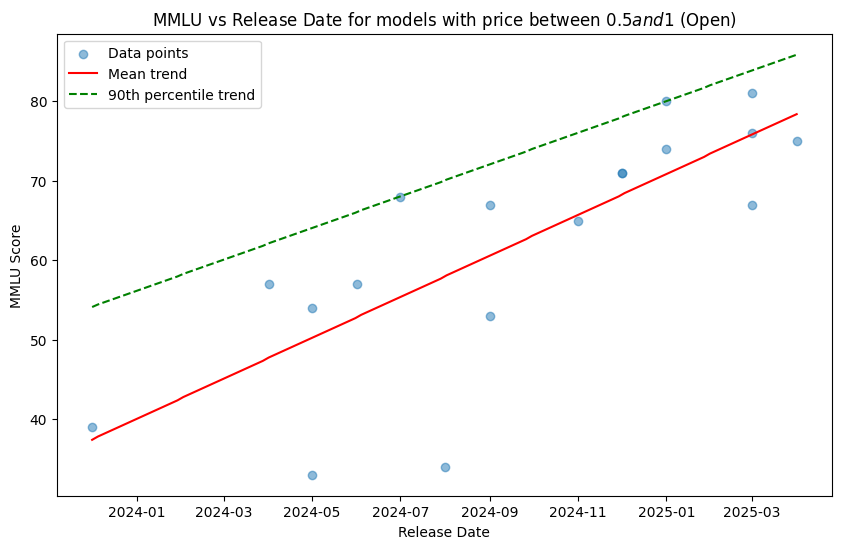

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_57345/4122245435.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_57345/4122245435.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Date_Numeric'] = pd.to_datetime(price_df['Release Date']).map(datetime.toordinal)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected

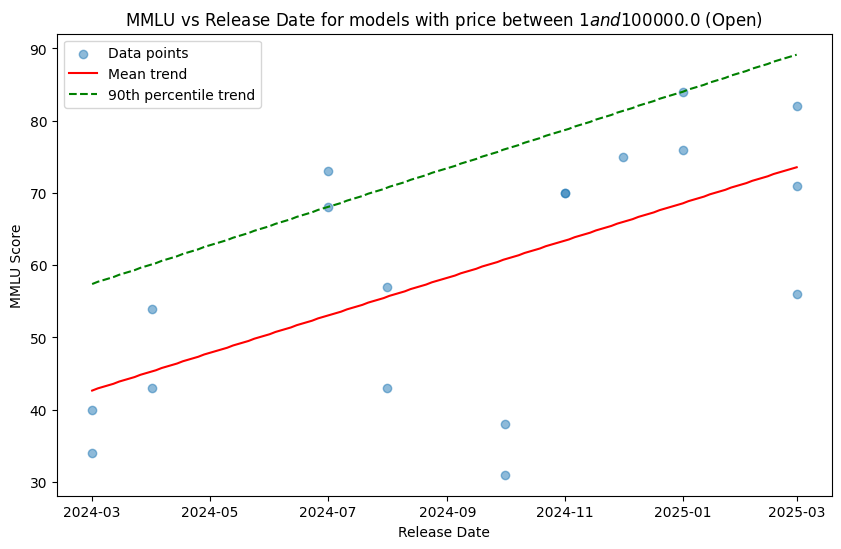

In [75]:
def plot_mmlu_vs_date_by_price(lower_price, upper_price, quantile=0.9, type='Open'):
    """
    Plots MMLU score vs. release date (month-level) for models with output price in a given range.
    Shows both mean and quantile regression trends.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
    from sklearn.linear_model import LinearRegression, QuantileRegressor

    df = pd.read_csv('art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
    benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    df = df[df['License'] == type]

    # Drop nan values
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]
    df = df[df['Output Price\nUSD/1M Tokens'].notna()]

    # Convert MMLU values to float
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)

    # Filter based on price
    price_df = df[(df['Output Price\nUSD/1M Tokens'] >= lower_price) & 
                  (df['Output Price\nUSD/1M Tokens'] <= upper_price)]

    # Convert release date to numeric for regression (ordinal)
    price_df['Date_Numeric'] = pd.to_datetime(price_df['Release Date']).map(datetime.toordinal)

    # Prepare regression variables
    X = price_df['Date_Numeric'].values.reshape(-1, 1)
    y = price_df[benchmark_feature].values.reshape(-1, 1)

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    daily_rate = model.coef_[0][0]
    yearly_rate = daily_rate * 365
    # For reporting, you could print or return yearly_rate if desired

    # Generate prediction line
    date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    mmlu_pred = model.predict(date_range)

    # Fit quantile regression
    quant_model = QuantileRegressor(quantile=quantile, alpha=0)
    quant_model.fit(X, y)
    mmlu_quant_pred = quant_model.predict(date_range)

    # Convert numeric dates back to datetime for plotting
    date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(price_df['Release Date'], price_df[benchmark_feature], alpha=0.5, label='Data points')
    plt.plot(date_range_dt, mmlu_pred, 'r-', label='Mean trend')
    plt.plot(date_range_dt, mmlu_quant_pred, 'g--', label=f'{quantile*100:.0f}th percentile trend')
    plt.xlabel('Release Date')
    plt.ylabel('MMLU Score')
    plt.title(f'MMLU vs Release Date for models with price between ${lower_price} and ${upper_price} ({type})')
    plt.legend()
    plt.show()

# Example usage:
plot_mmlu_vs_date_by_price(0.5, 1, quantile=0.9, type='Open')
plot_mmlu_vs_date_by_price(1, 1e5, quantile=0.9, type='Open')
# Example usage:

# Compare Both at Same Time:

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_57345/297807248.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


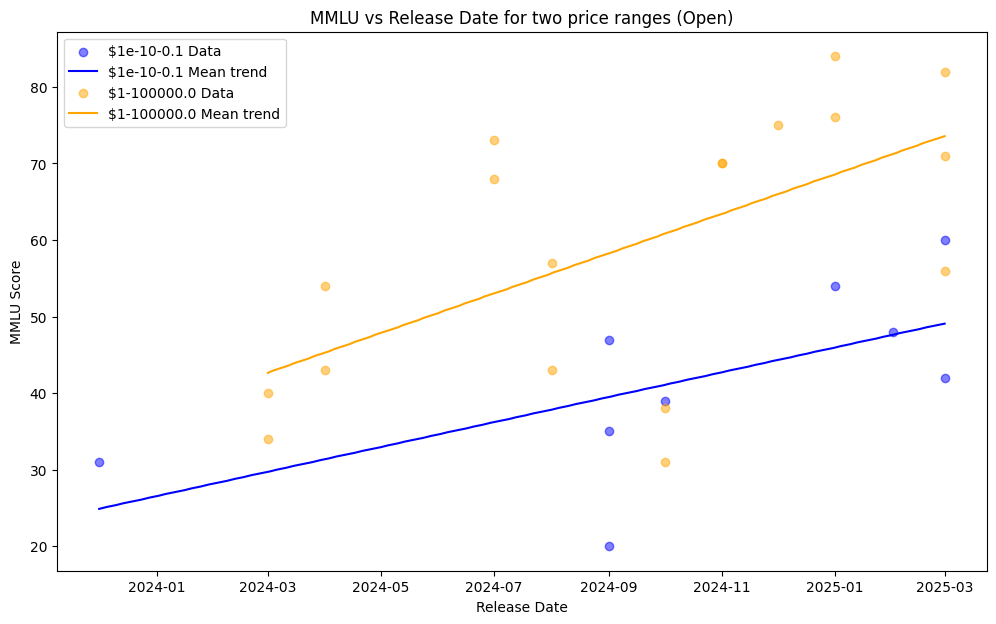

In [76]:
def compare_mmlu_vs_date_by_price(
    lower_price_1, upper_price_1, 
    lower_price_2, upper_price_2, 
    quantile=0.9, type='Open'
):
    """
    Plots MMLU score vs. release date for two price ranges on the same graph for comparison.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
    from sklearn.linear_model import LinearRegression, QuantileRegressor

    df = pd.read_csv('art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
    benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    df = df[df['License'] == type]

    # Drop nan values
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]
    df = df[df['Output Price\nUSD/1M Tokens'].notna()]

    # Convert MMLU values to float
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)

    # Helper function to get regression lines for a price range
    def get_regression_lines(lower_price, upper_price, color, label_prefix):
        price_df = df[(df['Output Price\nUSD/1M Tokens'] >= lower_price) & 
                      (df['Output Price\nUSD/1M Tokens'] <= upper_price)].copy()
        price_df['Date_Numeric'] = pd.to_datetime(price_df['Release Date']).map(datetime.toordinal)
        X = price_df['Date_Numeric'].values.reshape(-1, 1)
        y = price_df[benchmark_feature].values.reshape(-1, 1)
        if len(X) < 2:
            return None  # Not enough data
        # Linear regression
        model = LinearRegression()
        model.fit(X, y)
        date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        mmlu_pred = model.predict(date_range)
        # Quantile regression
        quant_model = QuantileRegressor(quantile=quantile, alpha=0)
        quant_model.fit(X, y)
        mmlu_quant_pred = quant_model.predict(date_range)
        date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]
        # Plot
        plt.scatter(price_df['Release Date'], price_df[benchmark_feature], alpha=0.5, label=f'{label_prefix} Data', color=color)
        plt.plot(date_range_dt, mmlu_pred, color=color, linestyle='-', label=f'{label_prefix} Mean trend')
        # plt.plot(date_range_dt, mmlu_quant_pred, color=color, linestyle='--', label=f'{label_prefix} {quantile*100:.0f}th percentile')
        return True

    plt.figure(figsize=(12, 7))
    got1 = get_regression_lines(lower_price_1, upper_price_1, 'blue', f'${lower_price_1}-{upper_price_1}')
    got2 = get_regression_lines(lower_price_2, upper_price_2, 'orange', f'${lower_price_2}-{upper_price_2}')
    plt.xlabel('Release Date')
    plt.ylabel('MMLU Score')
    plt.title(f'MMLU vs Release Date for two price ranges ({type})')
    plt.legend()
    plt.show()
    if not got1:
        print(f"Not enough data for price range ${lower_price_1}-{upper_price_1}")
    if not got2:
        print(f"Not enough data for price range ${lower_price_2}-{upper_price_2}")

# Example usage:
compare_mmlu_vs_date_by_price(1e-10, 0.1, 1, 1e5, quantile=0.9, type='Open')

# Best vs Fixed Price Range

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_52917/3436744081.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


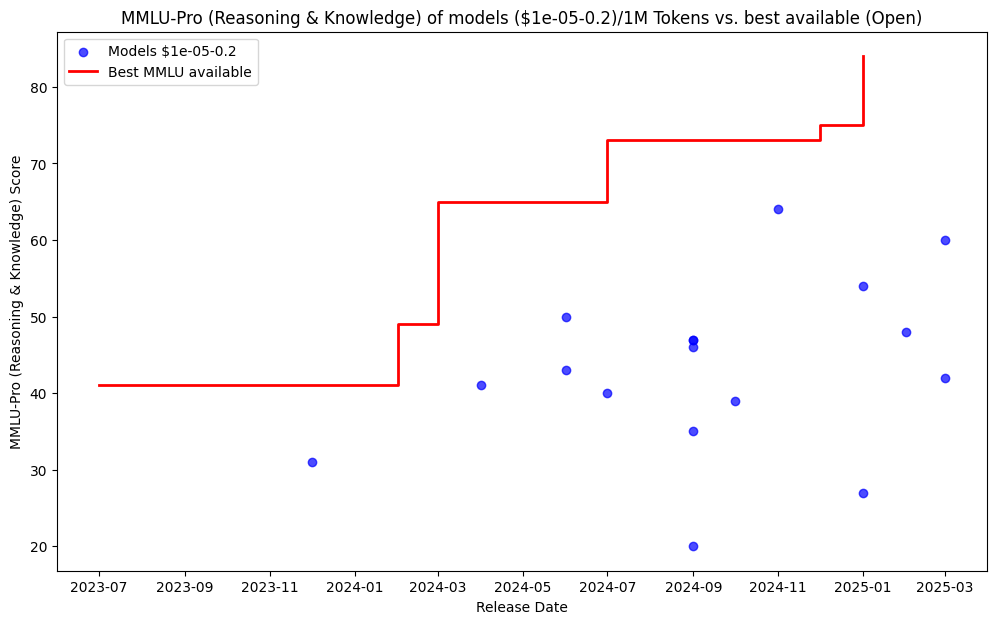

In [23]:
def compare_mmlu_to_best_over_time(lower_price, upper_price, type='Open'):
    """
    Plots MMLU performance of models within a fixed price range vs. the best MMLU available at each release date.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime

    df = pd.read_csv('Datasets/art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
    benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    df = df[df['License'] == type]

    # Drop nan values
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]
    df = df[df['Output Price\nUSD/1M Tokens'].notna()]

    # Convert MMLU values to float
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)

    # Sort by release date
    df = df.sort_values('Release Date')

    # Compute best MMLU available up to each date
    df['Best_MMLU_So_Far'] = df[benchmark_feature].cummax()

    # For plotting the best-available line, drop duplicates to get step points
    best_mmlu_df = df[['Release Date', 'Best_MMLU_So_Far']].drop_duplicates(subset='Best_MMLU_So_Far')

    # Filter models in the price range
    price_df = df[(df['Output Price\nUSD/1M Tokens'] >= lower_price) & 
                  (df['Output Price\nUSD/1M Tokens'] <= upper_price)]

    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(price_df['Release Date'], price_df[benchmark_feature], alpha=0.7, color='blue', label=f'Models ${lower_price}-{upper_price}')
    plt.step(best_mmlu_df['Release Date'], best_mmlu_df['Best_MMLU_So_Far'], where='post', color='red', linewidth=2, label='Best MMLU available')
    plt.xlabel('Release Date')
    plt.ylabel(f'{benchmark_feature} Score')
    plt.title(f'{benchmark_feature} of models (${lower_price}-{upper_price})/1M Tokens vs. best available ({type})')
    plt.legend()
    plt.show()

# Example usage:
compare_mmlu_to_best_over_time(0.00001, 0.2, type='Open')

# Pecent Decrease For Proprietary Models

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_4185/3391937126.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)


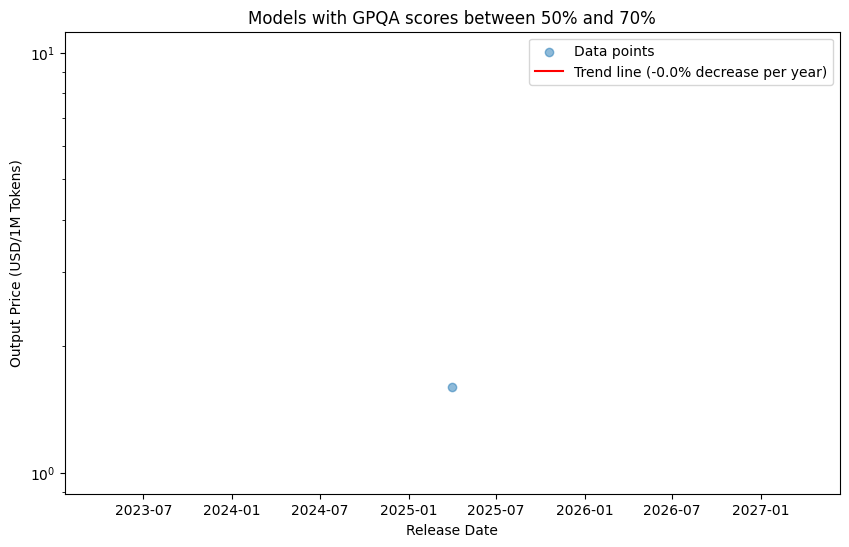

In [ ]:
# graph trend in price for models with GPQA in certain range
upper_level_gp = 70
lower_level_gp = 50

proprietary_df = proprietary_df
# Drop nan values
proprietary_df = proprietary_df[proprietary_df['GPQA Diamond (Scientific Reasoning)'].notna()]

# Convert GPQA values to float - handle the case where values are already numeric
# First check if the values are strings or already numeric
if proprietary_df['GPQA Diamond (Scientific Reasoning)'].dtype == 'object':
    # If they're strings, remove the % sign and convert
    proprietary_df['GPQA Diamond (Scientific Reasoning)'] = proprietary_df['GPQA Diamond (Scientific Reasoning)'].str.replace('%', '').astype(float)
else:
    # If they're already numeric, just ensure they're float type
    proprietary_df['GPQA Diamond (Scientific Reasoning)'] = proprietary_df['GPQA Diamond (Scientific Reasoning)'].astype(float)

# Filter based on GPQA - fix the logical operator (use 'and' or '&' with parentheses)
gpqa_df = proprietary_df[(proprietary_df['GPQA Diamond (Scientific Reasoning)'] >= lower_level_gp) & 
             (proprietary_df['GPQA Diamond (Scientific Reasoning)'] <= upper_level_gp)]

# Convert release date to numeric for regression


# Convert dates to numeric format for regression
gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)

# Take log of prices for linear regression, handling zeros and infinities
output_prices = gpqa_df['Output Price\nUSD/1M Tokens']
# Filter out zeros and negative values before taking log
valid_prices = output_prices[output_prices > 0]
gpqa_df_filtered = gpqa_df[output_prices > 0]
log_prices = np.log(valid_prices)

# Check for infinite values and remove them
mask = np.isfinite(log_prices)
gpqa_df_filtered = gpqa_df_filtered[mask]
log_prices = log_prices[mask]

# Fit linear regression model
X = gpqa_df_filtered['Date_Numeric'].values.reshape(-1, 1)
y = log_prices.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Calculate percent decrease per year
# The coefficient represents the change in log price per day
daily_rate = model.coef_[0][0]
# Convert to yearly rate
yearly_rate = daily_rate * 365
# Convert log change to percent change: e^yearly_rate - 1
percent_change_per_year = (np.exp(yearly_rate) - 1) * 100
# Since we expect a decrease, make it positive for reporting
percent_decrease_per_year = -percent_change_per_year

# Generate prediction line
date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
log_price_pred = model.predict(date_range)
price_pred = np.exp(log_price_pred)

# Convert numeric dates back to datetime for plotting
date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]

# Plot output price vs release date for gpqa_df with trend line
plt.figure(figsize=(10, 6))
plt.scatter(gpqa_df_filtered['Release Date'], gpqa_df_filtered['Output Price\nUSD/1M Tokens'], alpha=0.5, label='Data points')
plt.plot(date_range_dt, price_pred, 'r-', label=f'Trend line ({percent_decrease_per_year:.1f}% decrease per year)')
plt.xlabel('Release Date')
plt.ylabel('Output Price (USD/1M Tokens)')
plt.yscale('log')
plt.title(f'Models with GPQA scores between {lower_level_gp}% and {upper_level_gp}%')
plt.legend()

# Open Source Models

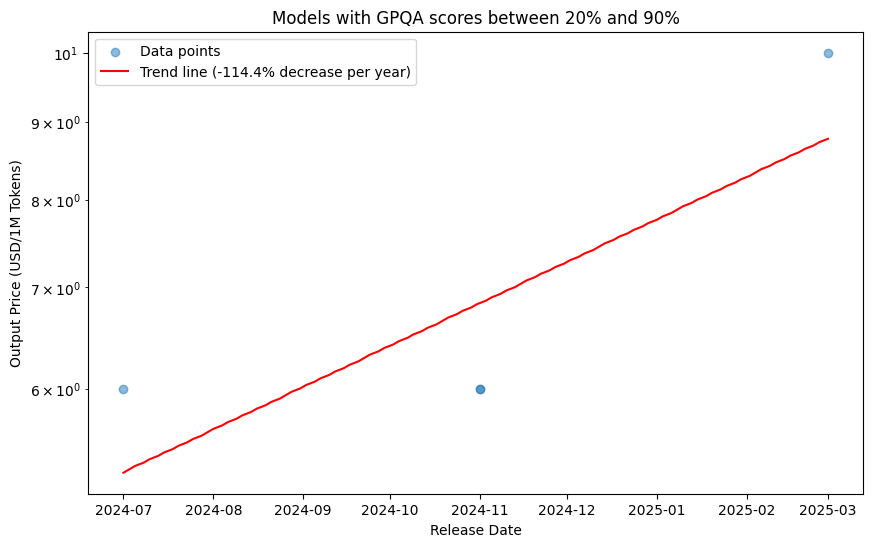

In [112]:
# graph trend in price for models with GPQA in certain range
upper_level_gp = 90
lower_level_gp = 20
#open source models

# Drop nan values
open_license_df = open_license_df[open_license_df['GPQA Diamond (Scientific Reasoning)'].notna()]

# Convert GPQA values to float - handle the case where values are already numeric
# First check if the values are strings or already numeric
if open_license_df['GPQA Diamond (Scientific Reasoning)'].dtype == 'object':
    # If they're strings, remove the % sign and convert
    open_license_df['GPQA Diamond (Scientific Reasoning)'] = open_license_df['GPQA Diamond (Scientific Reasoning)'].str.replace('%', '').astype(float)
else:
    # If they're already numeric, just ensure they're float type
    open_license_df['GPQA Diamond (Scientific Reasoning)'] = open_license_df['GPQA Diamond (Scientific Reasoning)'].astype(float)

# Filter based on GPQA - fix the logical operator (use 'and' or '&' with parentheses)
gpqa_df = open_license_df[(open_license_df['GPQA Diamond (Scientific Reasoning)'] >= lower_level_gp) & 
             (open_license_df['GPQA Diamond (Scientific Reasoning)'] <= upper_level_gp)]

# Convert release date to numeric for regression

# Convert dates to numeric format for regression
gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)

# Take log of prices for linear regression, handling zeros and infinities
output_prices = gpqa_df['Output Price\nUSD/1M Tokens']
# Filter out zeros and negative values before taking log
valid_prices = output_prices[output_prices > 0]
gpqa_df_filtered = gpqa_df[output_prices > 0]
log_prices = np.log(valid_prices)

# Check for infinite values and remove them
mask = np.isfinite(log_prices)
gpqa_df_filtered = gpqa_df_filtered[mask]
log_prices = log_prices[mask]

# Fit linear regression model
X = gpqa_df_filtered['Date_Numeric'].values.reshape(-1, 1)
y = log_prices.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Calculate percent decrease per year
# The coefficient represents the change in log price per day
daily_rate = model.coef_[0][0]
# Convert to yearly rate
yearly_rate = daily_rate * 365
# Convert log change to percent change: e^yearly_rate - 1
percent_change_per_year = (np.exp(yearly_rate) - 1) * 100
# Since we expect a decrease, make it positive for reporting
percent_decrease_per_year = -percent_change_per_year

# Generate prediction line
date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
log_price_pred = model.predict(date_range)
price_pred = np.exp(log_price_pred)

# Convert numeric dates back to datetime for plotting
date_range_dt = [datetime.fromordinal(int(d)) for d in date_range.flatten()]

# Plot output price vs release date for gpqa_df with trend line
plt.figure(figsize=(10, 6))
plt.scatter(gpqa_df_filtered['Release Date'], gpqa_df_filtered['Output Price\nUSD/1M Tokens'], alpha=0.5, label='Data points')
plt.plot(date_range_dt, price_pred, 'r-', label=f'Trend line ({percent_decrease_per_year:.1f}% decrease per year)')
plt.xlabel('Release Date')
plt.ylabel('Output Price (USD/1M Tokens)')
plt.yscale('log')
plt.title(f'Models with GPQA scores between {lower_level_gp}% and {upper_level_gp}%')
plt.legend()

# Proprietary Model Trends

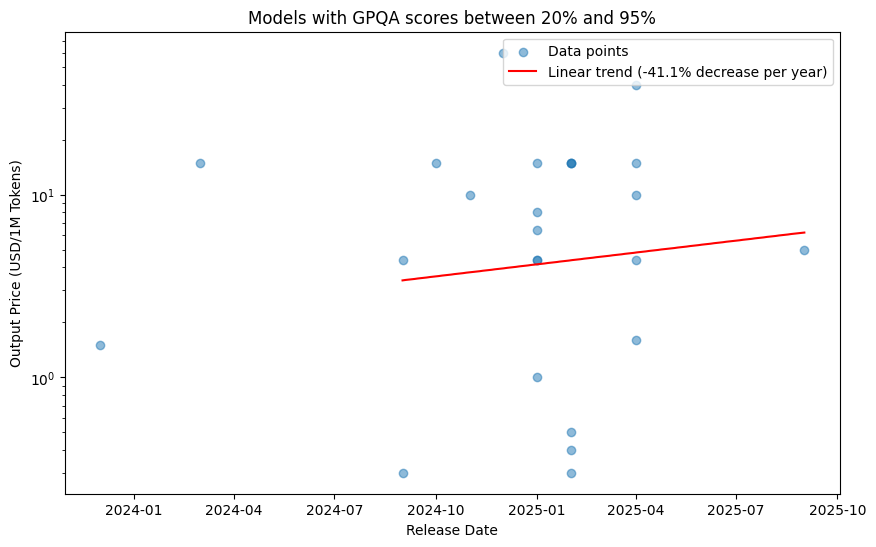

In [81]:


# Parameters for GPQA filter
upper_level_gp = 95
lower_level_gp = 20
quantile = 0.95

# Drop nan values
proprietary_df = proprietary_df[proprietary_df['GPQA Diamond (Scientific Reasoning)'].notna()]

# Convert GPQA values to float
if proprietary_df['GPQA Diamond (Scientific Reasoning)'].dtype == 'object':
    proprietary_df['GPQA Diamond (Scientific Reasoning)'] = (
        proprietary_df['GPQA Diamond (Scientific Reasoning)']
        .str.replace('%', '', regex=False)
        .astype(float)
    )
else:
    proprietary_df['GPQA Diamond (Scientific Reasoning)'] = proprietary_df['GPQA Diamond (Scientific Reasoning)'].astype(float)

# Filter based on GPQA
gpqa_df = proprietary_df[
    (proprietary_df['GPQA Diamond (Scientific Reasoning)'] >= lower_level_gp) &
    (proprietary_df['GPQA Diamond (Scientific Reasoning)'] <= upper_level_gp)
]

# Define price column name
price_col = 'Output Price\nUSD/1M Tokens'

# Convert release date to numeric for regression
gpqa_df['Date_Numeric'] = pd.to_datetime(gpqa_df['Release Date']).map(datetime.toordinal)

# Prepare price data for log transformation
output_prices = gpqa_df[price_col]
valid_mask = output_prices > 0
gpqa_df_filtered = gpqa_df[valid_mask].copy()
log_prices = np.log(output_prices[valid_mask])

# Remove infinite values
mask = np.isfinite(log_prices)
gpqa_df_filtered = gpqa_df_filtered[mask]
log_prices = log_prices[mask]

# Linear regression on log-prices
X = gpqa_df_filtered['Date_Numeric'].values.reshape(-1, 1)
y = log_prices.values.reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X, y)

daily_rate = lin_model.coef_[0][0]
yearly_rate = daily_rate * 365
percent_change_per_year = (np.exp(yearly_rate) - 1) * 100
percent_decrease_per_year = -percent_change_per_year

# Prediction line for linear regression
date_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
log_price_pred = lin_model.predict(date_range)
price_pred = np.exp(log_price_pred)





# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(
    gpqa_df_filtered['Release Date'],
    gpqa_df_filtered[price_col],
    alpha=0.5,
    label='Data points'
)
plt.plot(
    date_range_dt,
    price_pred,
    'r-',
    label=f'Linear trend ({percent_decrease_per_year:.1f}% decrease per year)'
)
plt.xlabel('Release Date')
plt.ylabel('Output Price (USD/1M Tokens)')
plt.yscale('log')
plt.title(f'Models with GPQA scores between {lower_level_gp}% and {upper_level_gp}%')
plt.legend()
plt.show()
